# Module 03: 1-D Diffusion Problem - Thawing Permafrost

### 1. Introduction and Background

In this notebook we are going to apply what we've learned about 1-dimensional diffusive processes to developing a model of how climate warming will effect permafrost. 


Below is the equation for 1-dimensional heat diffusion into a soil,
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

### 2. Applying a Numerical Solution

In this notebook, we will apply the backward time, centered space (BTCS) solution developed in Slingerland and Kump, an implicit method. As with the explicit case, we will divide our soil column into layers of equal thickness, specify boundary conditions at the top and bottom of our soil, as well as an initial condition and simulate the evolution of soil temperature over a 10 year period. We again skip the math of applying this method and go right to the finite difference solution, solveing for the soil temperature at the $(i+1)$th time in ___all soil layers simultaneously___,

$$
\mathbf{T}^{i+1} = \mathbf{A}^{-1} \mathbf{T}^i
$$

where the matrix $\mathbf{A}$ combines the centered space finite difference operator, and soil diffusivity as follows,

$$
\mathbf{A} = \left(D_s\frac{\Delta t}{\Delta z^2}\right)\left[\mathbf{I} - \mathbf{\Delta}_2\right]
$$

where $\mathbf{I}$ is the identity matrix, 

$$
\mathbf{I} = 
\begin{bmatrix}
    1 & 0 & 0 & \dots & 0 \\
    0 & 1 & 0 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots \\ 
    0 & \dots & \dots & 1 & 0 \\
    0 & \dots & \dots & 0 & 1    
\end{bmatrix}
$$


and $\mathbf{\Delta_2}$ is the centered space finite difference operator, given by,

$$
\mathbf{\Delta}_2 = 
\begin{bmatrix}
    -2 & 1 & 0 & \dots & 0 \\
    1 & -2 & 1 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots \\ 
    0 & \dots & 1 & -2 & 1 \\
    0 & \dots & \dots & 1 & -2
\end{bmatrix}
$$

For our __top boundary condition__, we will assume sinusoidal forcing of air temperature at the surface, with a period of one year. We will then need to specify the mean annual temperature around which the surface air temperature fluctuates, and the amplitude of annual fluctuations. In this notebook we will use realistic, but synthetic, values for each. 

For our __bottom boundary condition__, we will assume a constant temperature at the mean annual air temperature specified above. 

Our __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 3. Initial Setup and Creating the Domain

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

# Time properties of simulation
t0 = 0
tf = 10*365
dt = 0.20

# Boundary conditions
Ttopbase = -7.0
Ttopamp = 35.0
Tbottom = -7.0

#### 3.1 Setup the Soil Column Spatial Domain

In [2]:
z = np.arange(dz/2, zs, dz)
Nz = z.size
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


#### 3.2 Setup the Simulation Time Period

In [3]:
t = np.arange(t0,tf+dt,dt)
Nt = t.size
print('Here are the time steps: t = \n' + str(t))
print('The number of time steps: Nt = ',str(Nt))

Here are the time steps: t = 
[0.0000e+00 2.0000e-01 4.0000e-01 ... 3.6496e+03 3.6498e+03 3.6500e+03]
The number of time steps: Nt =  18251


#### 3.3 Calculate the Soil Diffusivity and Diffusion Number

In [4]:
# Calculate diffusivity of permafrost soil
Ds = ks / (rhos * Cs)
print('Soil diffusivity = '+str(Ds)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
Ds = Ds*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(Ds)+' cm^2/day')

alpha = Ds*dt/(dz**2)
print('Diffusion number '+str(alpha))

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Diffusion number 0.3286545703526189


#### 3.4 Setup the Incidence Matrix $\mathbf{A}$

In [5]:
Delta2 = np.diag(-2.0*np.ones((Nz))) + np.diag(np.ones((Nz-1)),1) + np.diag(np.ones((Nz-1)),-1)
print(Delta2)

[[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -2.]]


In [6]:
I = np.eye(Nz)
A = I - alpha*Delta2
A[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))
print(A)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [-0.32865457  1.65730914 -0.32865457 ...  0.          0.
   0.        ]
 [ 0.         -0.32865457  1.65730914 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.65730914 -0.32865457
   0.        ]
 [ 0.          0.          0.         ... -0.32865457  1.65730914
  -0.32865457]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


### 4. Setup Boundary and Initial Conditions

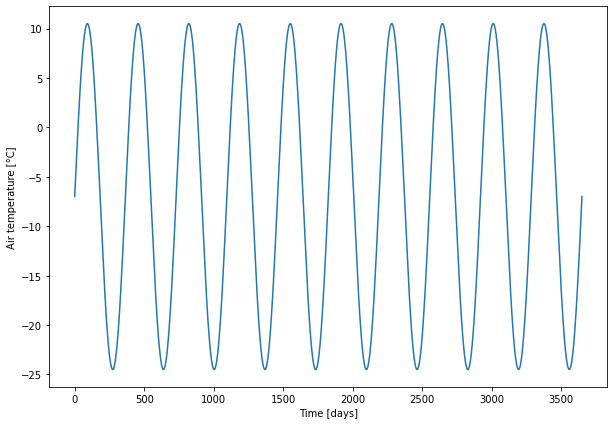

In [7]:
Ttop = Ttopbase + (Ttopamp/2.0)*np.sin((2.0*np.pi/(365.0))*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t,Ttop)
plt.xlabel('Time [days]')
plt.ylabel('Air temperature [°C]')

Ts0 = Tbottom*np.ones((Nz,1))

### 5. Preallocate Memory for Temperature Simulation


In [8]:
Ts = np.zeros((Nz,Nt))

### 6. Apply BTCS Solution And Compute Temperatures

In [9]:
Ainv = np.linalg.pinv(A)
for i in np.arange(Nt):
    if(i==0):
        Tsi = Ts0
    else:
        Tsi = Ts[:,i-1]
        Tsi[0] = Ttop[i]
        Tsi[-1] = Tbottom
    
    Tsip1 = np.matmul(Ainv,Tsi)
    
    Ts[:,i] = np.squeeze(Tsip1)

### 7. Plot Results, Analyze, and Interpret

First, let's create a pretty visualization of how temperature in the soil column changes with both depth below the surface and time. We will use the `pcolormesh` function in `matplotlib`. 

Text(0, 0.5, 'Soil depth [cm]')

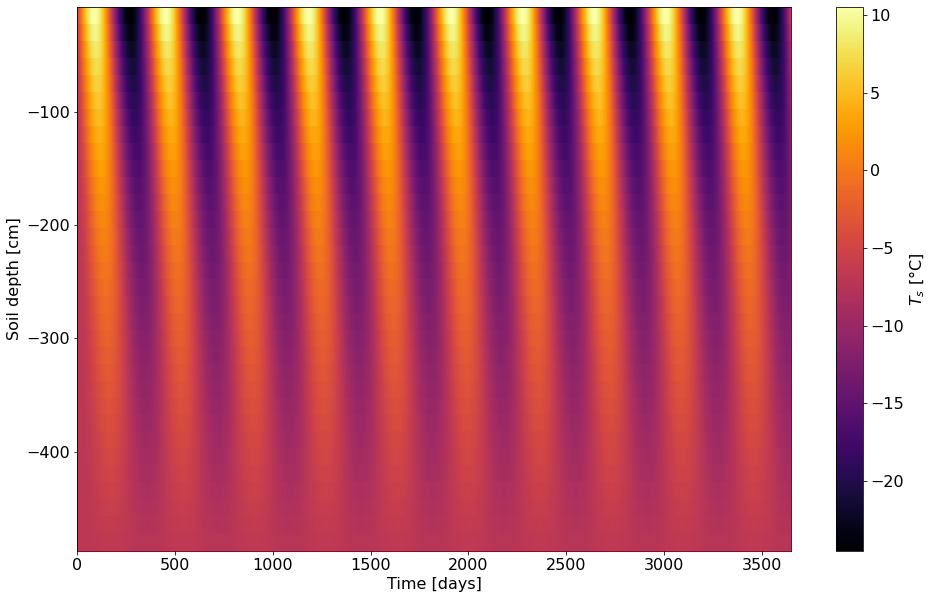

In [10]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

tt,zz = np.meshgrid(t,z)

plt.figure(figsize=(16,10)) # Create a figure and set the size

# Notice we're plotting -zz to have the top of the soil at the top and negative
# into the land surface
plt.pcolormesh(tt,-zz,Ts,cmap='inferno') 
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')

Next, let's examine how the soil temperature evolves at several depths within the soil. Specifically, let's look at depths of 50, 100, 200, and 400 cm below the surface and plot how the temperature varies through time. Some important questions here:

* At what depth do we no longer cross above 0.0 °C in any given year? What can we say about the active layer thickness based on this? 
* What happens to the amplitude of the annual temperature fluctuations as we go deeper in the soil? 
* What happens to the timing of the peak temperature as we go deeper into the soil? 

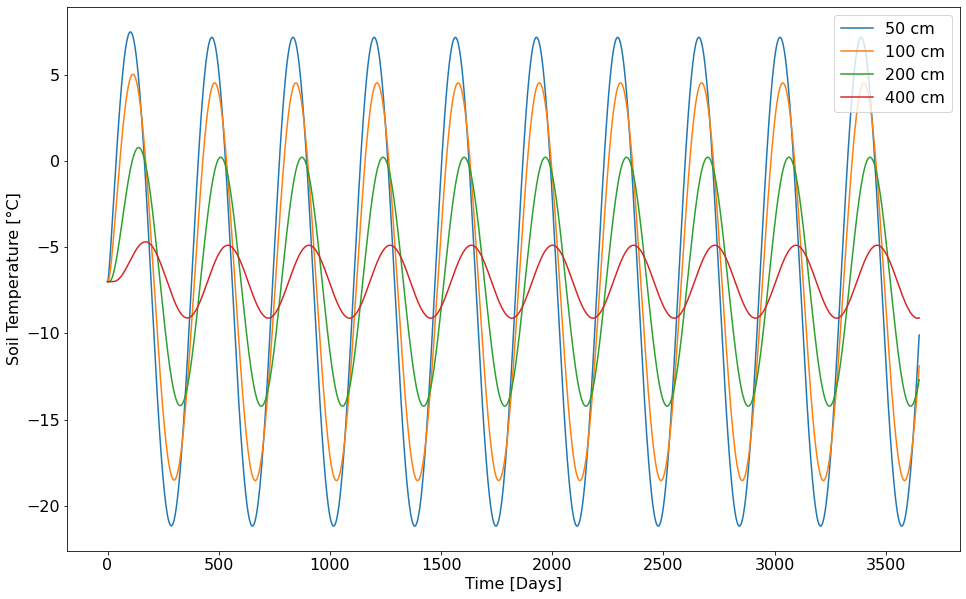

In [11]:
iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()

plt.figure(figsize=(16,10))
plt.plot(t,Ts[iz50,:],label='50 cm')
plt.plot(t,Ts[iz100,:],label='100 cm')
plt.plot(t,Ts[iz200,:],label='200 cm')
plt.plot(t,Ts[iz400,:],label='400 cm')
plt.xlabel('Time [Days]')
plt.ylabel('Soil Temperature [°C]')
plt.legend()

Finally, let's repeat the 3-D plot of temperature versus time and depth into the soil, but we'll mask values that are above 0 °C and plot them as blue (i.e., something that's very different than our previous colormap). This will allow us to see more clearly where the permafrost has thawed (i.e., it's temperature is above 0 °C) and how long it remains thawed. Some key questions we could address or concepts we can show by plotting the data this way include:

* What is the approximate thickness of the active layer based on this plot?
* How long throughout the year does the near surface (e.g., the top 10 cm) stay thawed each year?
* Do we notice any appreciable trends in active layer thickness at this time horizon? Why or why would you not expect one? 

Text(0, 0.5, 'Soil depth [cm]')

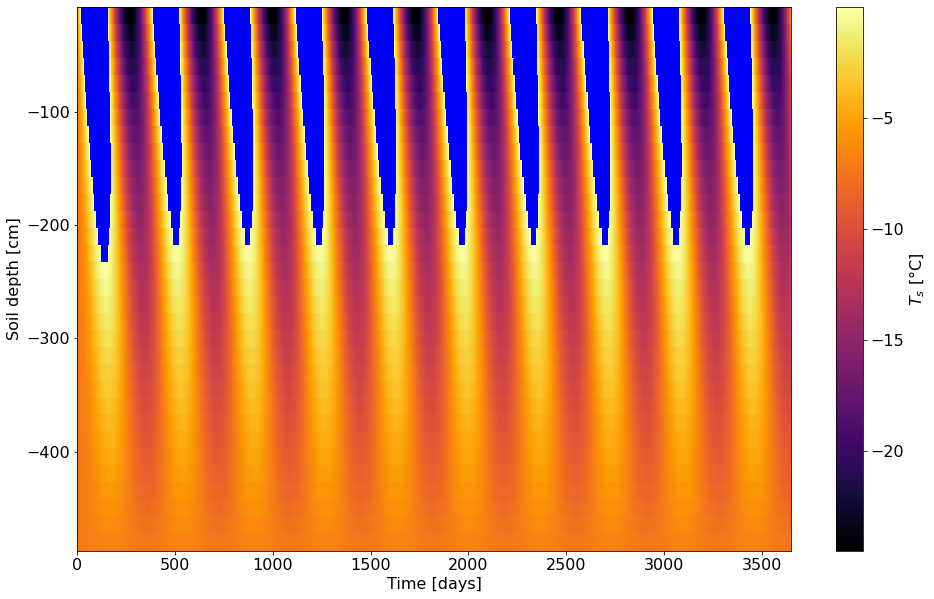

In [12]:
Ts_frozen = np.ma.masked_where(Ts>0.0,Ts)

plt.figure(figsize=(16,10))
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
plt.pcolormesh(tt,-zz,Ts_frozen,cmap=current_cmap)
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [days]')
plt.ylabel('Soil depth [cm]')

### 8. A Final Couple Reflection Questions

As you review this notebook, think about the following:

* Why does the active layer seem to be thicker in the first year of the simulation? 
* If we changed the layer thickness $\Delta z$, do we have to change the time step $\Delta t$? Why? 